# Labeling function writing workshop

This workshop aims at making LF writing more interative and incorporating effective feedback in the loop, on abstract segmentation, from slimmed top tier CS papers. This notebook is the material for this LF writing workshop within MegaCognition Lab.

As a result, we load in ~1375 top-tier CS papers 

Selection criteria is venue-based, as below.
`selected_top_tier=["UbiComp","IJCAI", "IEEE Visualization", "SIGCOMM", "Computer Supported Cooperative Work (CSCW)", "POPL", "AAAI", "CIKM", "WWW", "NAACL", "EMNLP", "ACL", "CSCW", "CVPR", "INFOCOM", "ICML", "CHI", "KDD", "ICCV", "ICWSM", "UIST"]`



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
debug_mode=1 # if not in debug mode, please set debug_mode=0, find more info about debug mode in test run 9 maybe?
%load_ext autoreload
%autoreload 2
%matplotlib inline

## I. Background
### A. Preprocessing the Corpus and Save to the Database (Done)

The corpus could be downloaded [here](https://github.com/xeniaqian94/snorkel/blob/master/abstractnet/testrun/data/slim-slim-top-tier-citation).

In [2]:
import os
os.environ['SNORKELDB'] = "postgresql:///abstractnetwordworkshopslim"
print(os.environ['SNORKELDB'])
from snorkel import SnorkelSession
from snorkel.parser import TSVDocPreprocessor
session = SnorkelSession()

## Here, we just set the upperbound for how many documents we'll process!
n_docs = 3000 
doc_preprocessor = TSVDocPreprocessor('data/slim-slim-top-tier-citation', encoding="utf-8",max_docs=n_docs)

from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor, count=n_docs)# ,parallelism=5)

from snorkel.models import Document, Sentence  # defined in context.py file
print("Documents:", session.query(Document).count())

postgresql:///abstractnetwordworkshopslim
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True


/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Clearing existing...
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
clearning..
clear finished!
Running UDF...
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
[========================================] 100%

CPU times: user 32 s, sys: 751 ms, total: 32.7 s
Wall time: 45.8 s
Documents: 1375


### B. Connect to the Database and retrieve Document

Recall the Document/Sentence/Candidate hierarchy in the guideline. We also divide the whole document set into buckets of each 100 documents.

In [3]:
from snorkel import SnorkelSession
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser
from snorkel.models import Document, Sentence
from collections import defaultdict
import numpy as np

session = SnorkelSession()
docs = session.query(Document).all()
sents = session.query(Sentence).all()  # get all sentences from snorkel.db

docs_per_bucket=100
sents_split=defaultdict(lambda:[])
for ind, doc in enumerate(docs):
    bucket=int(ind/docs_per_bucket)
    for s in doc.sentences:
        sents_split[bucket]+=[s]
print("Number of buckets", len(sents_split))

Number of buckets 14


### C. From Documents to Extract Candidates

Here we extract the candidates (i.e. unigrams) from one of the document bucket, which has approximately 100 documents. Here we use <b>Bucket 0</b>. So it is our train bucket to learn the generative model from LFs. Later we will use <b>Bucket 1</b> as the development bucket, to draw visualizations and provide feedbacks. 

In [4]:
from snorkel.models import candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import *
import datetime

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

Unigram = candidate_subclass('Unigram', ['unigram_cue'],values=['PP','MN','NULL'])
ngrams = Ngrams(n_max=1) 
ngram_matcher=NgramMatcher()
unigram_segment_extractor=CandidateExtractor(Unigram,[ngrams],[ngram_matcher])

train_bucket=0
%time unigram_segment_extractor.apply(sents_split[train_bucket], split=train_bucket)
unigram_segments=session.query(Unigram).filter(Unigram.split == train_bucket).all()
print("Number of Candidates/Unigrams",len(unigram_segments))

Clearing existing...
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
clearning..
Running UDF...
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
[========================================] 100%

CPU times: user 32.9 s, sys: 2.21 s, total: 35.1 s
Wall time: 1min 7s
Number of Candidates/Unigrams 21694


### D. Data Exploration 

Let's visualize some Candidates/Unigrams with SentenceNgramViewer. 

In [5]:
from snorkel.viewer import SentenceNgramViewer

unigram_segments=session.query(Unigram).filter(Unigram.split == train_bucket).all()
SentenceNgramViewer(unigram_segments[0:100], session, n_per_page=10)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[0, 5, 8, 11, 15, 19, 21, 26, 33, 35, 38, 39, 41, 42, 44, 47, 49, 51, 52, 56, 59, 6…

## II. Labeling Functions
### A. Load the n-th version of LFs

In this n-th version, a majority of our LFs are cue-based LFs. You can tell from the names!

In [6]:
from snorkel.lf_helpers import *
from snorkel.annotations import LabelAnnotator

from LF.util_common_default_categorical import purpose_LFs,mechanism_LFs,null_LFs
print("total LF count", len(purpose_LFs+mechanism_LFs+null_LFs), "unique count",len(set(purpose_LFs+mechanism_LFs+null_LFs)),"purpose_LFs",len(purpose_LFs),"mechanism_LFs",len(mechanism_LFs))
print("\n\npurpose_LFs\n",[lf.__name__ for lf in purpose_LFs])
print("\n\nmechanism_LFs\n",[lf.__name__ for lf in mechanism_LFs])
print("\n\nnull_LFs\n",[lf.__name__ for lf in null_LFs])

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


total LF count 139 unique count 139 purpose_LFs 55 mechanism_LFs 34


purpose_LFs
 ['LF_purpose_TO_VB_neg2_True', 'LF_purpose_goal3_True', 'LF_purpose_goalneg2_True', 'LF_purpose_the_problem_of3_True', 'LF_purpose_the_problem_ofneg2_True', 'LF_purpose_the_task_of3_True', 'LF_purpose_the_task_ofneg2_True', 'LF_purpose_challenging3_True', 'LF_purpose_challengingneg2_True', 'LF_purpose_challenge3_True', 'LF_purpose_challengeneg2_True', 'LF_purpose_fundamental3_True', 'LF_purpose_fundamentalneg2_True', 'LF_purpose_issue3_True', 'LF_purpose_issueneg2_True', 'LF_purpose_allow_3_True', 'LF_purpose_allow_neg2_True', 'LF_purpose_allows_3_True', 'LF_purpose_allows_neg2_True', 'LF_purpose_useful_to3_True', 'LF_purpose_useful_toneg2_True', 'LF_purpose_task3_True', 'LF_purpose_taskneg2_True', 'LF_purpose_investigate3_True', 'LF_purpose_investigateneg2_True', 'LF_purpose_we_study3_True', 'LF_purpose_we_studyneg2_True', 'LF_purpose_although3_True', 'LF_purpose_althoughneg2_True', 'LF_purpose_however3

## VI. Development Sandbox
### A. Writing New Labeling Functions

We will name them as `new_LFs`.

In [7]:
#
# PLACE YOUR LFs HERE
#
new_LFs=[]

### B. Applying Labeling Functions

In here we define two functions: (1) applying LFs to get an annotation matrix; (2) use the annotation matrix to learn a generative model.

In [8]:
from snorkel.learning import GenerativeModel
from util import get_candidate_text
import matplotlib.pyplot as plt
import datetime

def get_L_train(LFs,parallelism=1,split=0):
    L_train=None
    labeler=None
    np.random.seed(1701)
    labeler = LabelAnnotator(lfs=LFs)
    print(datetime.datetime.now())
    L_train = labeler.apply(split=split,parallelism=parallelism)# ,cids_query=session.query(Candidate.id).filter(Candidate.get_parent().id %10==1))
    print(datetime.datetime.now())
    print(type(L_train))
    print(L_train.shape)
    printmd("**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  "+str(L_train.non_overlapping_coverage()))
    return L_train

def get_train_marginals(L_train,step_size_nominator=0.1,epochs=100,lf_propensity=True,threads=1,class_prior=False,decay=1.0,reg_param=1e-6):
    try:
        gen_model=None
        print(datetime.datetime.now())
        gen_model = GenerativeModel(lf_propensity=lf_propensity,class_prior=class_prior)
        gen_model.train(L_train, cardinality=3, epochs=epochs, decay=decay,step_size=step_size_nominator/1e2,reg_param=reg_param,verbose=False,threads=threads)
        print("training finished ")
        print(datetime.datetime.now())
        print("Finished training generative model, now checking performance against development set labels...")
        print("Calculating marginals!")
        train_marginals = gen_model.marginals(L_train)  # the marginal probability of each candidate being True
        print("no exception")
        print(datetime.datetime.now())
        return gen_model,train_marginals
    except:
        print("exception! ")
        return gen_model,train_marginals


In [9]:
L_train=get_L_train(purpose_LFs+mechanism_LFs+null_LFs+new_LFs)
print(L_train.shape)

snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
2018-10-16 22:02:02.153330
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
cids_count 21694
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
clearning..
Running UDF...
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
[========================================] 100%

2018-10-16 22:05:20.476752
<class 'snorkel.annotations.csr_LabelMatrix'>
(21694, 133)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6605513045081589

(21694, 133)


In [10]:
import pandas as pd 
pd.set_option('display.max_rows', 500)

df=L_train.lf_stats(session)
df['Conflict_Coverage_ratio'] = df['Conflicts']/df['Coverage']

df.sort_values(by=['Conflict_Coverage_ratio'],ascending=False)

,j,Coverage,Overlaps,Conflicts,Conflict_Coverage_ratio
LF_null_evaluated_3_True,100,0.000184,0.000184,0.000184,1.000000
LF_purpose_the_task_of3_True,5,0.000092,0.000092,0.000092,1.000000
LF_purpose_the_task_ofneg2_True,6,0.001890,0.001890,0.001890,1.000000
LF_mechanism_to_solve_3_True,80,0.000277,0.000277,0.000277,1.000000
LF_mechanism_to_solve_neg2_True,81,0.004010,0.004010,0.004010,1.000000
LF_null_evaluated_neg2_True,101,0.001060,0.001060,0.001060,1.000000
LF_null_evaluate_neg2_True,103,0.005439,0.005347,0.005163,0.949153
LF_purpose_allows_neg2_True,18,0.009911,0.009450,0.008389,0.846512
LF_purpose_althoughneg2_True,28,0.009957,0.009450,0.008343,0.837963
LF_null_compared_toneg2_True,127,0.003181,0.003181,0.002489,0.782609


In [ ]:
# for reg_param in [1e-3]:#,1e-6]: #[1e-3, 1e-6]:
#     for decay in [0.95]: #[1.0,0.95]:
#         for step_size_nominator in [0.01,0.001]: # [0.01, 0.1, 1]:
#             for epochs in [2,3,4,5,7,10]:#,30,50,100,200,500]:
#                 for lf_propensity in [False]:
                    
#                     print("grid search with L_train","step_size_nominator",step_size_nominator,"epochs",epochs,"decay",decay,"reg_param",reg_param,"lf_propensity",lf_propensity)
#                     gen_model,train_marginals=get_train_marginals(L_train,threads=18,lf_propensity=lf_propensity,step_size_nominator=step_size_nominator,epochs=epochs,decay=decay,reg_param=reg_param)
#                     assert np.all(train_marginals.sum(axis=1) - np.ones(train_marginals.shape[0]) < 1e-10)

#                     winHighlight=train_marginals.argmax(axis=1)
#                     print("PP",(winHighlight==0).sum())
#                     print("MN",(winHighlight==1).sum())
#                     print("NULL",(winHighlight==2).sum())

#                     # Amendment!!! winning highligh with default as NULL (the last occurence of largest value)
#                     train_marginals_reverse = train_marginals[:,::-1]
#                     winHighlight = train_marginals.shape[1] - np.argmax(train_marginals_reverse,axis=1) - 1
#                     print("amend PP",(winHighlight==0).sum())
#                     print("amend MN",(winHighlight==1).sum())
#                     print("amend NULL",(winHighlight==2).sum())


### C. Learning the Generative Model

In [11]:
reg_param=1e-3
decay=0.95
step_size_nominator=0.01
epochs=5
lf_propensity=False
                        
gen_model,train_marginals=get_train_marginals(L_train,threads=18,step_size_nominator=step_size_nominator,lf_propensity=lf_propensity,epochs=epochs,decay=decay,reg_param=reg_param)
assert np.all(train_marginals.sum(axis=1) - np.ones(train_marginals.shape[0]) < 1e-10)

winHighlight=train_marginals.argmax(axis=1)
print("PP",(winHighlight==0).sum())
print("MN",(winHighlight==1).sum())
print("NULL",(winHighlight==2).sum())

# Amendment!!! winning highligh with default as NULL (the last occurence of largest value)
train_marginals_reverse = train_marginals[:,::-1]
winHighlight = train_marginals.shape[1] - np.argmax(train_marginals_reverse,axis=1) - 1
print("amend PP",(winHighlight==0).sum())
print("amend MN",(winHighlight==1).sum())
print("amend NULL",(winHighlight==2).sum())

2018-10-16 23:33:55.483797
Compiles variable matrix
_compile finished!
Compiles variable matrix
_compile finished!
training finished 
2018-10-16 23:35:28.033645
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
no exception
2018-10-16 23:35:32.544189
PP 14297
MN 4155
NULL 3242
amend PP 6933
amend MN 4155
amend NULL 10606


### D. Visualize generative labels on this train set, then on the dev set

0
10000
20000
dispatch finished!! 
visualizing docid semanticDBLP_6ac53e1ce1c4710736226e3d850282a7323a160b
visualizing docid semanticDBLP_c3d62bcb84fc3a2aa9b8f4691677d7c02738f1bc
visualizing docid semanticDBLP_3afe4a92dbc660e65cb7d2fcde773e1f7eedf870
visualizing docid semanticDBLP_0e8f6d6b5a5c11058b0104aa8e1e747c96d57d65
visualizing docid semanticDBLP_916cc725b419df58a5ead57bcc597178ff8ce913
visualizing docid semanticDBLP_001cecf6d3dfb29c56e71c417455c705a4bf290c
visualizing docid semanticDBLP_146f5b0743e17a5a31baea6475bdc8fedd81e641
visualizing docid semanticDBLP_d566f6863fd3c2ccd14411ac4fcdbe77408322e3
visualizing docid semanticDBLP_aa05431d82f5d85a3abdf2f4d416c36993b1284b
visualizing docid semanticDBLP_6f7c97bd40689fc34a4e8eb383d922d1b625ed23
visualizing docid semanticDBLP_0f4fe8951ab76e14c3838882a0833f44eb705a4f
visualizing docid semanticDBLP_082d9df20b38a85177e2df4accddaaf064781032
visualizing docid semanticDBLP_045df65fbc57c340b3b1341155bbfe274c0c2503
visualizing docid semanticDBL

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


visualizing docid semanticDBLP_cf23b1f94e6a2547707ee7a134f18920afb4ddd5
visualizing docid semanticDBLP_0384de8ece83cd3788a8c9ca03120a31fb301785
visualizing docid semanticDBLP_1effff1f70f788df26b74cea9987055b8eadf61b
visualizing docid semanticDBLP_8b15d471ec0f90930ee09f61b9ac45ca8c766298
visualizing docid semanticDBLP_7b638a5b73e7bc6732d7ae52f5695f6a28c1aeef
visualizing docid semanticDBLP_68bcec979052bcb8e060c481d3dcfa3d651ef401
visualizing docid semanticDBLP_d4f072d45ba717788cf7a4d955a7103ed06c2f17
visualizing docid semanticDBLP_131d9428e919cd5c5206b8a5dcf3be838f98b26f
visualizing docid semanticDBLP_1bada64240b629958bf8cfc819c5fdb6b83eddbe
visualizing docid semanticDBLP_0557d50516257ebf1c902f797433bb89e67fd811
visualizing docid semanticDBLP_5ecd4e3bc3ad84c698ada20ee1df1d7c5366ac37
visualizing docid semanticDBLP_0c04a213c6ec18542faee526fa43ecc85c465356
visualizing docid semanticDBLP_1e31a76ab19abcd9dbac35c88e9bf8fe9c39ee83
visualizing docid semanticDBLP_856a5e56564b1dbb8881b7180d6620eb1

visualizing docid semanticDBLP_1c3fd3831a0cc3f8b3a64aa0e579cc6d9bc35d48
visualizing docid semanticDBLP_a4fef1d8d6a09e1ee921e2d3c47c01316b2bb890
visualizing docid semanticDBLP_5a60244957e52bdbf1627fd9d70b11044c8a2c0c
visualizing docid semanticDBLP_34bf02183c48ec300e40ad144efcdfe67dacd681
visualizing docid semanticDBLP_0886fba7d24a16840442a718fc7ce3a05bf937fe
visualizing docid semanticDBLP_180a6b1d248d7a9cb1632a7e5d978aa6d5f86d53
visualizing docid semanticDBLP_7158bf071ece8d20332f0f6b0b06d5ae0de2c0c5
visualizing docid semanticDBLP_b97a29712ad698387509bf91a68181a9758034e7
visualizing docid semanticDBLP_100f1691322b2d48d561d9aabeaebe9e7269d47c
visualizing docid semanticDBLP_a15403373ac2bb2eeb0d99423772a0603b131638
visualizing docid semanticDBLP_ea37bfdc9fcebe154fa9f78f4f9bf36d1e55d10b
visualizing docid semanticDBLP_12ba2eb20f7d345e4b6ada54f811d3bb26608932
visualizing docid semanticDBLP_d4d9e30e9287e3216fa8bd021d88b9ab775fe487
visualizing docid semanticDBLP_48612da20ccacf0562586acf24cd1ab7b

<Figure size 432x288 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

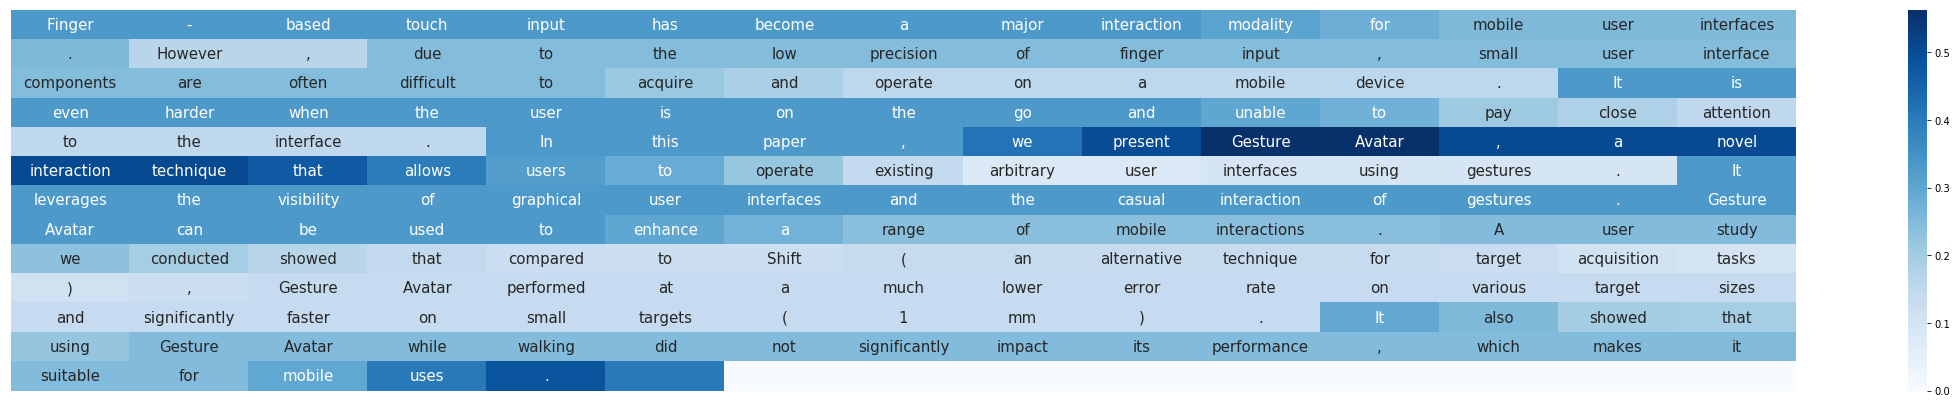

In [12]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import os 

def pad_reshape(A,width,isFloat=False):
    B=np.empty([1,int(A.shape[1]/width+1)*width],dtype=object)
    if isFloat:
        B=np.zeros([1,int(A.shape[1]/width+1)*width])
        B[:,:A.shape[1]]=A
    else:
        B[:,:A.shape[1]]=A
        B[:,A.shape[1]:]=""
    return B.reshape(-1,width)
 

def create_new_score_array(smooth_window,score_array,word_array):
    new_score_array=np.zeros(score_array.shape)
    half_window=int(smooth_window/2)
    punctuation=[",","."]
    for i in range(score_array.shape[1]):
        sub_score_array=score_array[0,max(0,i-half_window):i+half_window+1]
        sub_word_array=word_array[0,max(0,i-half_window):i+half_window+1]

        mid_pos=half_window

        left_pos=mid_pos
        right_pos=mid_pos
#         print(sub_word_array[left_pos],type(sub_word_array[left_pos]))
        while left_pos>0 and str(sub_word_array[left_pos-1][0]) not in punctuation:
            left_pos-=1
        while right_pos<len(sub_word_array):
            right_pos+=1
            if str(sub_word_array[right_pos-1][0]) in punctuation:
                break
        new_score_array[0,i]=np.mean(sub_score_array[left_pos:right_pos])
    return new_score_array


    
def visualize_word_level(tag,unigram_segments,score_list,directory="data/word_level_tag_visualization",smooth_window=0,cmap="Greens"):
    doc_dict=defaultdict(lambda:[])

    pair_list=list(zip(unigram_segments,score_list))

    for ind,pair in enumerate(pair_list):
        if ind%10000==0:
            print(ind)
        docid=pair[0].get_parent().get_parent().name
        doc_dict[docid]+=[pair]
    print("dispatch finished!! ")

    for docid in doc_dict:
        plt.clf()
        doc_dict[docid]=sorted(doc_dict[docid], key=lambda pair: (pair[0].get_parent().position, pair[0].get_contexts()[0].get_word_start()))
        ordered_word_score_list=[(pair[0].get_parent().text[pair[0].unigram_cue.char_start:pair[0].unigram_cue.char_end+1], pair[1]) for pair in doc_dict[docid]]
        df=pd.DataFrame.from_records(ordered_word_score_list,columns=['word','score'])
        fig, ax = plt.subplots(figsize=(40,7))  
        width=15
        score_array=np.asarray(df[['score']]).reshape(1,-1)
        word_array=np.asarray(df[['word']]).reshape(1,-1)
        
        if smooth_window!=0:
            score_array=create_new_score_array(smooth_window,score_array,word_array)
#             print(new_score_array.shape)
        sns.heatmap(pad_reshape(score_array,width,isFloat=True), cmap=cmap, annot=pad_reshape(word_array,width),fmt='',yticklabels=False,xticklabels=False,ax=ax,annot_kws={"size": 15})
        plt.savefig(os.path.join(directory,"run",docid+"_"+tag))
  
sample_size=train_marginals.shape[0]
# visualize_word_level("PP",unigram_segments[:sample_size],list(train_marginals[:sample_size,0].reshape(-1))) 
# visualize_word_level("MN",unigram_segments[:sample_size],list(train_marginals[:sample_size,1].reshape(-1)))

smooth_window=3
visualize_word_level("PP"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,0].reshape(-1)),smooth_window=smooth_window,cmap="Reds") 
visualize_word_level("MN"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,1].reshape(-1)),smooth_window=smooth_window,cmap="Blues") 

We could now view visualization on this train set back in the directory.

In [ ]:
blind_bucket=1
%time unigram_segment_extractor.apply(sents_split[blind_bucket], split=blind_bucket)
unigram_segments_tmp=session.query(Unigram).filter(Unigram.split == blind_bucket).all()

L_train_tmp=get_L_train(purpose_LFs+mechanism_LFs+null_LFs+new_LFs,split=blind_bucket)
print("creating blind_marginals")

train_marginals_tmp = gen_model.marginals(L_train_tmp)
print("visualizing blind_marginals")
sample_size=train_marginals_tmp.shape[0]
smooth_window=3
visualize_word_level("PP"+"_"+str(smooth_window),unigram_segments_tmp[:sample_size],list(train_marginals_tmp[:sample_size,0].reshape(-1)),smooth_window=smooth_window,cmap="Reds",directory="data/word_level_tag_visualization/blind") 
visualize_word_level("MN"+"_"+str(smooth_window),unigram_segments_tmp[:sample_size],list(train_marginals_tmp[:sample_size,1].reshape(-1)),smooth_window=smooth_window,cmap="Blues",directory="data/word_level_tag_visualization/blind") 

Clearing existing...
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
clearning..
Running UDF...
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
[========================================] 100%

CPU times: user 39.4 s, sys: 3.06 s, total: 42.5 s
Wall time: 1min 26s
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
2018-10-16 23:44:27.250143
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
cids_count 21384
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
clearning..
Running UDF...
snorkel_conn_string postgresql:///abstractnetwordworkshopslim
if snorkel_postgres? True
[==============                          ] 33%

We could now view visualization on this blind set back in the directory. Look for important mismatch between the visualized segmentation and any missed LFs.

### Workshop stops at here! 

### Peripheral codes to examine Candidates

In [48]:
# TODO get_surrounding_words maybe group segments back to doc level from  Sentence has words in its __dict__ 

# visualize purpose probability


# pair_list=list(zip(unigram_segments,list(train_marginals[:,0].reshape(-1))))


# Find a test case span!!!
# count=0
# for idx,segment in enumerate(unigram_segments):
#     if "Specifically" in segment.get_parent().__dict__['words']:
#         print(idx,segment.get_parent().__dict__['text'])
#         if count>30:
#             break
#         count+=1
    
# input()
purpose_LFs=[]
from LF.util_common_default_categorical import purpose_LFs,mechanism_LFs

for i in range(695,725):
    print(unigram_segments[i])
    print(unigram_segments[i].get_parent().__dict__['text'])
    print(purpose_LFs[-1](unigram_segments[i]))
#     print(purpose_LFs[-1].__name__)
    print()
    
    
# print(unigram_segments[165],)

segment=unigram_segments[165]
# print((segment.get_contexts()[0].__dict__))
docid=segment.get_parent().get_parent().name
print(segment)
print("sent __dict__",segment.get_parent().__dict__)
print("sent pos in doc??", segment.get_parent().position)
# print("sent pos in doc??", segment.get_parent().get_parent().sentences.index(segment.get_parent()))

print(docid)

# print(segment.get_parent().get_parent().__dict__)
print(segment.get_parent().text[segment.unigram_cue.char_start:segment.unigram_cue.char_end+1])

unigram_psn=segment.unigram_cue.get_word_start()
print("unigram position?? ",unigram_psn)#.__dict__['words'])

its_pos_tag=segment.get_parent().__dict__['pos_tags'][unigram_psn]
print("its_pos_tag",its_pos_tag,"\n")

# its_surrounding_pos_tag=get_sourrounding_pos_tag(segment,3)
# print("unigram pos tag",get_sourrounding_pos_tag(segment,1))
# print("trigram pos tag",get_sourrounding_pos_tag(segment,3))
# print("5gram pos tag",get_sourrounding_pos_tag(segment,5))


Unigram(Span("b'tend'", sentence=2248, chars=[39,42], words=[9,9]))
Specifically, we showed that (a) users tend to like stories submitted by friends and (b) users tend to like stories their friends read and liked.
0

Unigram(Span("b'like'", sentence=2248, chars=[103,106], words=[23,23]))
Specifically, we showed that (a) users tend to like stories submitted by friends and (b) users tend to like stories their friends read and liked.
0

Unigram(Span("b'to'", sentence=2248, chars=[44,45], words=[10,10]))
Specifically, we showed that (a) users tend to like stories submitted by friends and (b) users tend to like stories their friends read and liked.
0

Unigram(Span("b'stories'", sentence=2248, chars=[108,114], words=[24,24]))
Specifically, we showed that (a) users tend to like stories submitted by friends and (b) users tend to like stories their friends read and liked.
0

Unigram(Span("b'like'", sentence=2248, chars=[47,50], words=[11,11]))
Specifically, we showed that (a) users tend to like